In [1]:
!unzip data.zip

Archive:  data.zip
  inflating: aug_test.csv            
  inflating: aug_train.csv           
  inflating: sample_submission.csv   


In [2]:
#@title 2. 필수 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# Scikit-learn (전처리 및 평가)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# LightGBM 모델 임포트 (원본 스니펫에서 임포트 확인)
import lightgbm as lgb

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# 시각화 기본 설정
sns.set_style('whitegrid')

In [ ]:
#@title 3. [중요] 데이터 경로 설정 및 로드

BASE_PATH = "./" # <--- 이 경로를 수정하세요

TRAIN_PATH = os.path.join(BASE_PATH, "aug_train.csv") # (Kaggle 원본 파일명: aug_train.csv)
TEST_PATH = os.path.join(BASE_PATH, "aug_test.csv")   # (Kaggle 원본 파일명: aug_test.csv)
SUB_PATH = os.path.join(BASE_PATH, "sample_submission.csv") # (제출 양식 파일)

try:
    df_train = pd.read_csv(TRAIN_PATH)
    df_test = pd.read_csv(TEST_PATH)
    df_sub = pd.read_csv(SUB_PATH)
    print("Train, Test, Submission files loaded successfully.")
except FileNotFoundError:
    print(f"Error: Files not found in {BASE_PATH}.")
    print("Please upload 'aug_train.csv' and 'aug_test.csv' and verify the BASE_PATH.")

print(f"\nTraining data shape: {df_train.shape}")
print(f"Test data shape: {df_test.shape}")
df_train.head()

Train, Test, Submission files loaded successfully.

Training data shape: (19158, 14)
Test data shape: (2129, 13)


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


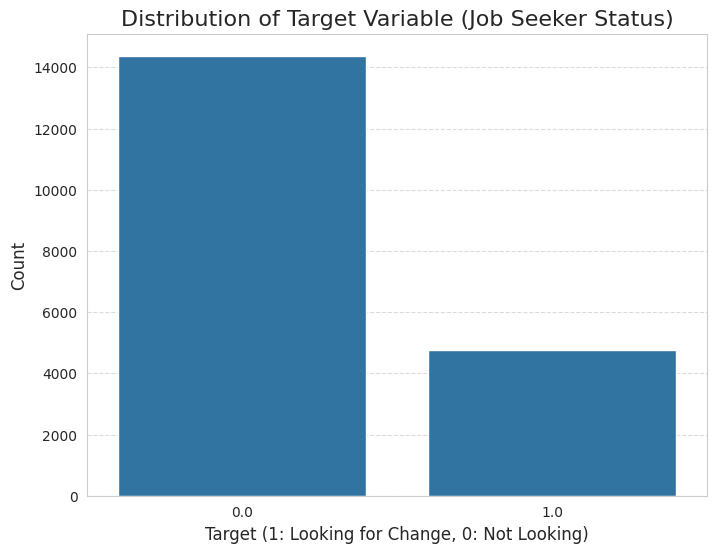

Target Ratio:
target
0.0    0.750652
1.0    0.249348
Name: proportion, dtype: float64

Analysis: This is an imbalanced dataset. Class 0 significantly outnumbers Class 1.


In [4]:
#@title 4. [EDA 보강] Target 분포(불균형) 확인 (영문 Plot)

# (Target: 0 = Not looking for job change, 1 = Looking for job change)
plt.figure(figsize=(8, 6))
sns.countplot(data=df_train, x='target')
plt.title('Distribution of Target Variable (Job Seeker Status)', fontsize=16)
plt.xlabel('Target (1: Looking for Change, 0: Not Looking)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

target_ratio = df_train['target'].value_counts(normalize=True)
print(f"Target Ratio:\n{target_ratio}")
print("\nAnalysis: This is an imbalanced dataset. Class 0 significantly outnumbers Class 1.")


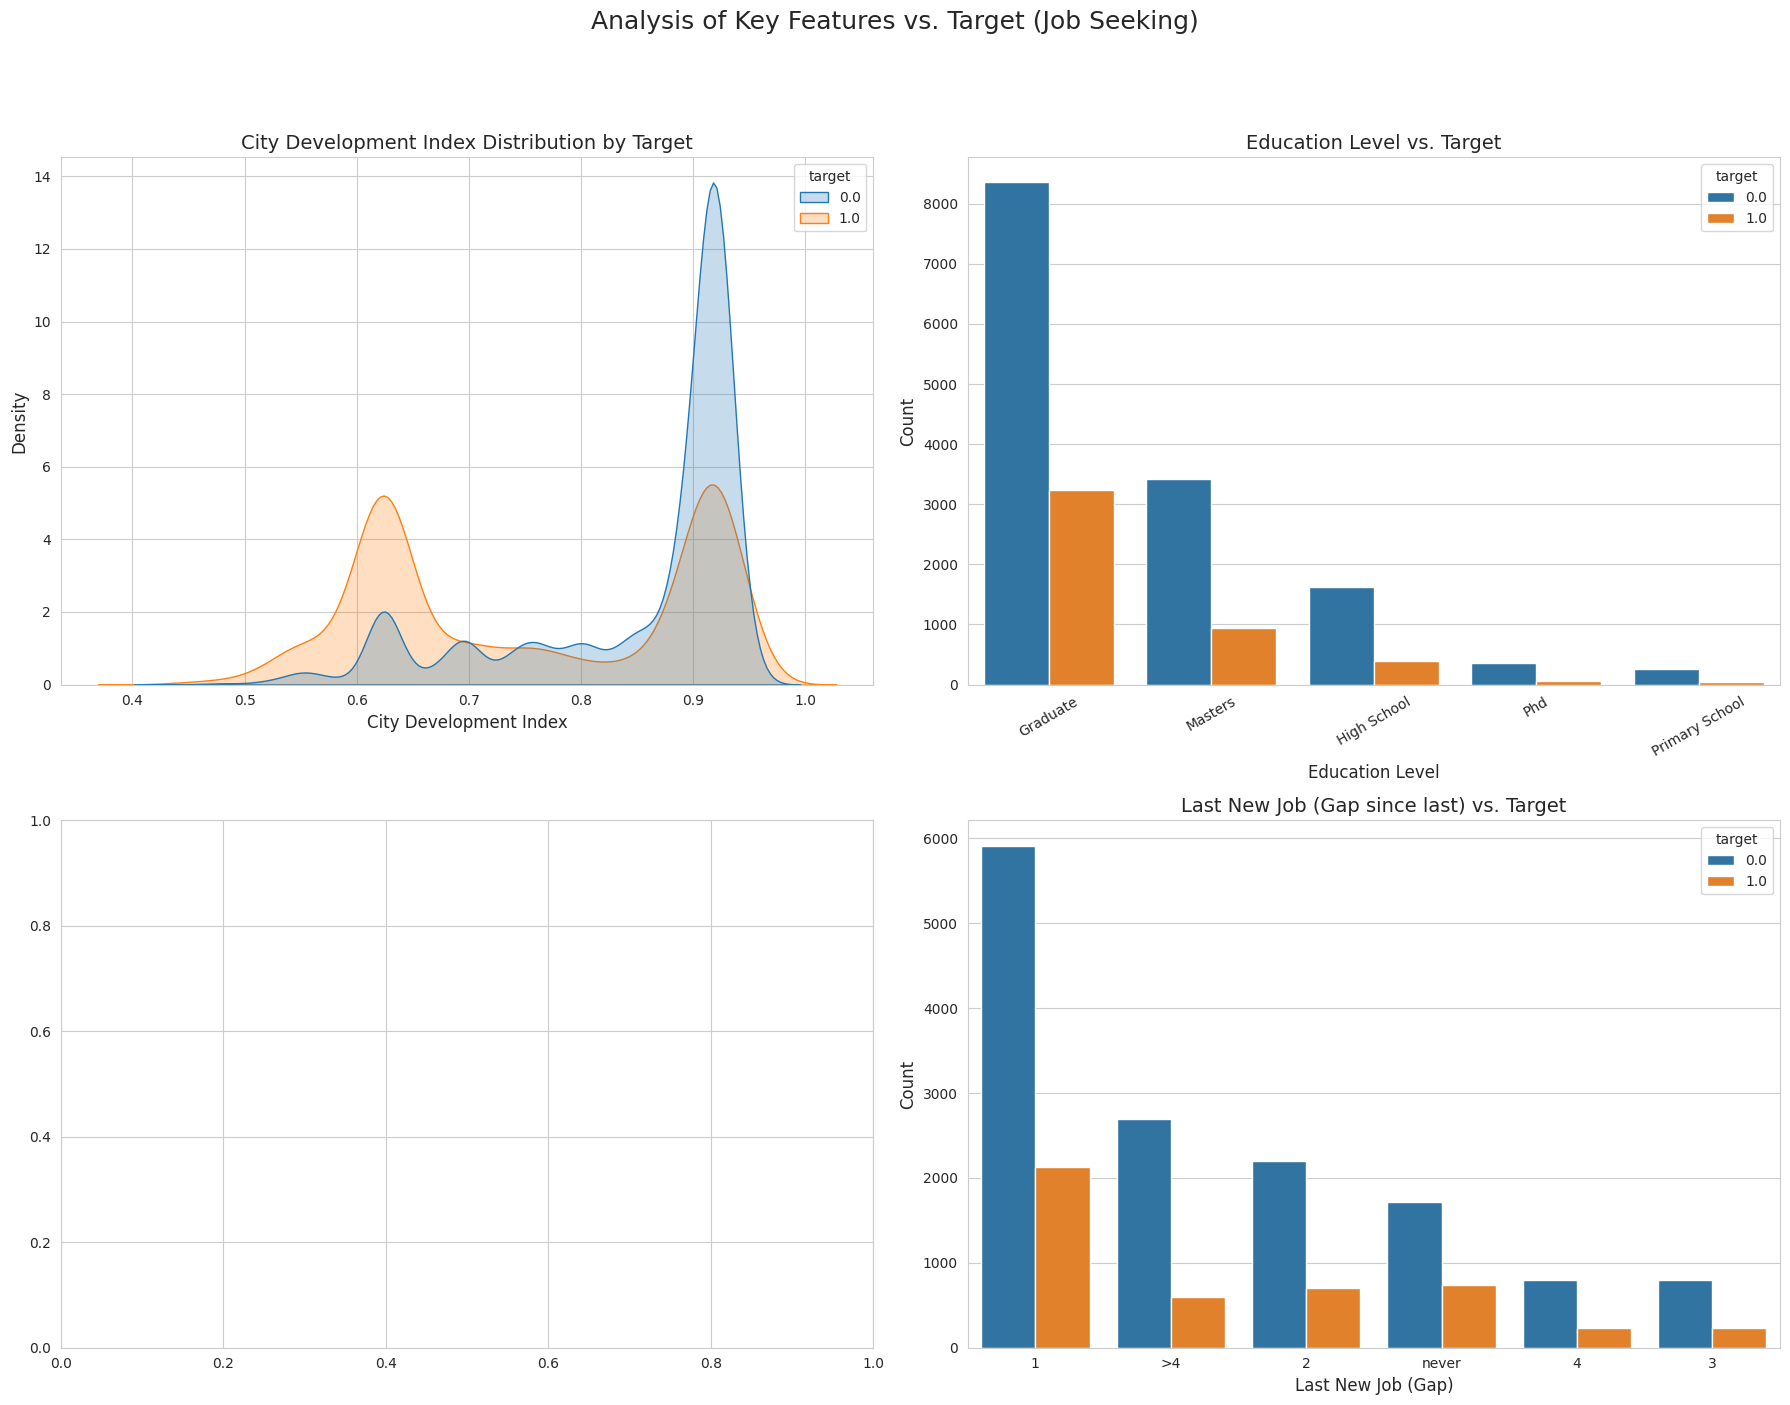

In [6]:
#@title 5. [EDA 보강] 주요 피처별 구직 희망 비율 (영문 Plot)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 14))
fig.suptitle('Analysis of Key Features vs. Target (Job Seeking)', fontsize=18, y=1.03)

# 1. 도시 개발 지수 (Continuous)
sns.kdeplot(data=df_train, x='city_development_index', hue='target', fill=True, common_norm=False, ax=axes[0, 0])
axes[0, 0].set_title('City Development Index Distribution by Target', fontsize=14)
axes[0, 0].set_xlabel('City Development Index', fontsize=12)
axes[0, 0].set_ylabel('Density', fontsize=12)

# 2. 교육 수준 (Categorical)
sns.countplot(data=df_train, x='education_level', hue='target', ax=axes[0, 1])
axes[0, 1].set_title('Education Level vs. Target', fontsize=14)
axes[0, 1].set_xlabel('Education Level', fontsize=12)
axes[0, 1].set_ylabel('Count', fontsize=12)
axes[0, 1].tick_params(axis='x', rotation=30)

# 4. 마지막 신규 직무 (Categorical)
sns.countplot(data=df_train, x='last_new_job', hue='target', order=df_train['last_new_job'].value_counts().index, ax=axes[1, 1])
axes[1, 1].set_title('Last New Job (Gap since last) vs. Target', fontsize=14)
axes[1, 1].set_xlabel('Last New Job (Gap)', fontsize=12)
axes[1, 1].set_ylabel('Count', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

In [7]:
#@title 6. 데이터 전처리 (결측치 및 범주형 인코딩)

def preprocess(df):
    # 'enrollee_id'는 식별자이므로 제거 (test셋에서도 제거)
    if 'enrollee_id' in df.columns:
        df = df.drop(columns=['enrollee_id'])

    # 결측치(NaN) 처리
    # (범주형은 'Missing'으로, 수치형은 -1 또는 0 등으로 채움)
    cat_cols = df.select_dtypes(include='object').columns
    num_cols = df.select_dtypes(exclude='object').columns.drop('target', errors='ignore')

    for col in cat_cols:
        df[col] = df[col].fillna('Missing')

    for col in num_cols:
        df[col] = df[col].fillna(0) # (0 또는 .median() 등 사용 가능)

    # 범주형(Object) 데이터를 LabelEncoder로 변환
    # (LGBM은 Category 타입으로 변환하는 것이 더 좋지만, LabelEncoding도 잘 작동함)
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))

    return df

In [8]:
print("Starting preprocessing...")
df_train_proc = preprocess(df_train.copy())
# [중요] Test셋도 동일하게 전처리 (단, target은 없음)
df_test_proc = preprocess(df_test.copy())

# LGBM에서 사용할 피처 목록 (target 제외)
FEATURES = [col for col in df_train_proc.columns if col not in ['target']]
TARGET = 'target'

# LGBM이 인식할 수 있도록 범주형 피처 이름 지정
# (LabelEncoder로 변환된 컬럼들)
categorical_features = df_train_proc.select_dtypes(include='int').columns.drop(['target', 'training_hours'], errors='ignore').tolist()
print(f"Identified Categorical Features for LGBM: {categorical_features}")

print("\nPreprocessing complete.")
df_train_proc.head()

Starting preprocessing...
Identified Categorical Features for LGBM: ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']

Preprocessing complete.


,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,5,0.920,1,0,3,0,6,21,8,2,0,36,1.0
1,77,0.776,1,1,3,0,6,6,4,6,4,47,0.0
2,64,0.624,2,1,0,0,6,15,8,2,6,83,0.0
3,14,0.789,2,1,1,0,1,20,8,6,6,52,1.0
4,50,0.767,1,0,3,2,6,21,4,1,3,8,0.0


In [9]:
#@title 7. [모델 검증] Train / Validation 분리 및 LGBM 학습

# 1. 훈련 데이터(df_train_proc)를 다시 훈련셋/검증셋으로 분리
X = df_train_proc[FEATURES]
y = df_train_proc[TARGET]

# (불균형 데이터이므로 'stratify=y' 필수)
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2, # 20%를 검증용으로 사용
    random_state=42,
    stratify=y
)

print(f"Training shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

# 2. LightGBM 모델 정의 (LGBMClassifier)
lgbm = lgb.LGBMClassifier(
    objective='binary',      # 이진 분류
    metric='auc',            # 평가 지표: AUC (불균형 데이터에 적합)
    is_unbalance=True,       # [중요] 타겟 불균형 처리를 위한 옵션
    n_estimators=1000,       # 트리 개수 (아래 early_stopping으로 최적화됨)
    learning_rate=0.05,
    n_jobs=-1,
    random_state=42
)

print("\nStarting model training...")

# 3. 모델 학습 (조기 종료 활성화)
lgbm.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],           # 검증셋 지정
    eval_metric='auc',
    callbacks=[lgb.early_stopping(100, verbose=False)], # 100 라운드 동안 AUC 개선 없으면 중지
    categorical_feature=categorical_features # 범주형 피처 지정
)

print("Model training finished.")

Training shape: (15326, 12)
Validation shape: (3832, 12)

Starting model training...
[LightGBM] [Info] Number of positive: 3822, number of negative: 11504
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 528
[LightGBM] [Info] Number of data points in the train set: 15326, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.249380 -> initscore=-1.101921
[LightGBM] [Info] Start training from score -1.101921
Model training finished.


--- Model Evaluation on Validation Set ---
Validation Accuracy: 78.91%
Validation AUC Score: 0.8219

[Classification Report (English)]
                 precision    recall  f1-score   support

Not Looking (0)       0.92      0.79      0.85      2877
    Looking (1)       0.55      0.78      0.65       955

       accuracy                           0.79      3832
      macro avg       0.74      0.79      0.75      3832
   weighted avg       0.83      0.79      0.80      3832


Plotting Confusion Matrix...


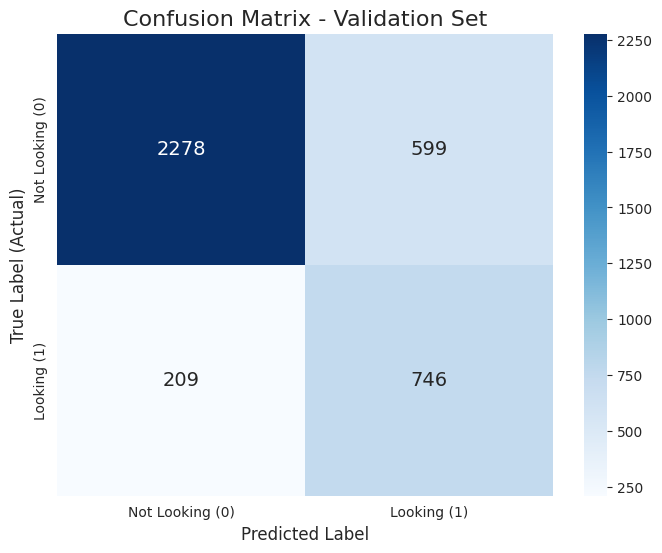

In [10]:
#@title 8. [결과 분석 보강] 모델 평가 (리포트, AUC, 혼동 행렬)

print("--- Model Evaluation on Validation Set ---")

# 1. 검증셋 예측 (확률 및 클래스)
y_pred_proba = lgbm.predict_proba(X_val)[:, 1] # (Class 1에 대한 확률)
y_pred_class = lgbm.predict(X_val)

# 2. 평가지표 계산
auc_score = roc_auc_score(y_val, y_pred_proba)
accuracy = accuracy_score(y_val, y_pred_class)

print(f"Validation Accuracy: {accuracy*100:.2f}%")
print(f"Validation AUC Score: {auc_score:.4f}")

# 3. 분류 리포트 (Classification Report)
print("\n[Classification Report (English)]")
print(classification_report(y_val, y_pred_class, target_names=['Not Looking (0)', 'Looking (1)']))

# 4. [시각화] 혼동 행렬 (Confusion Matrix)
print("\nPlotting Confusion Matrix...")
cm = confusion_matrix(y_val, y_pred_class)
class_names = ['Not Looking (0)', 'Looking (1)']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={"size": 14})
plt.title('Confusion Matrix - Validation Set', fontsize=16)
plt.ylabel('True Label (Actual)', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()


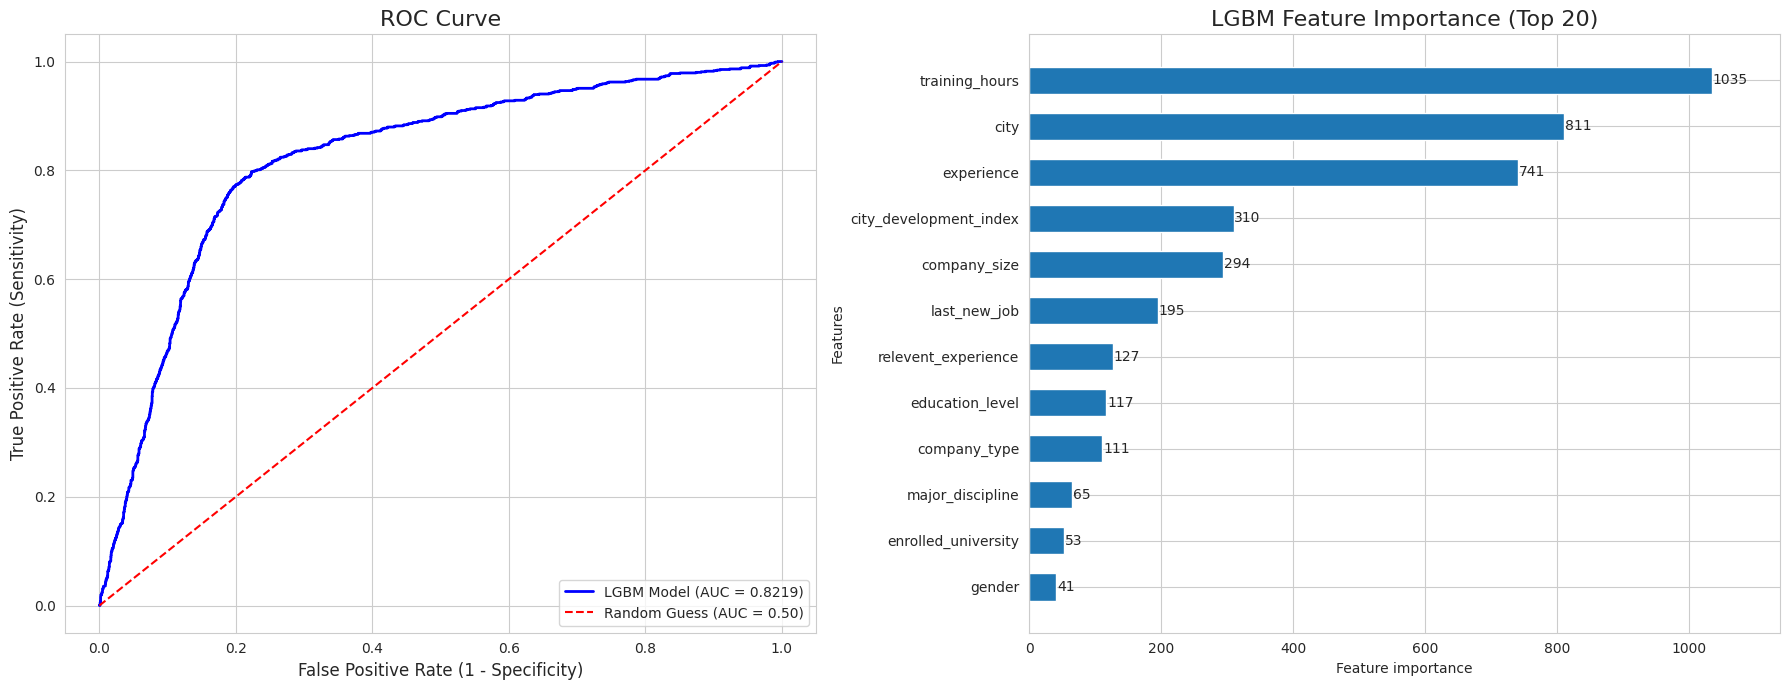

Analysis: Feature importance shows which factors (like city index, experience, company size) the model relies on most.


In [11]:
#@title 9. [결과 분석 보강] ROC 커브 및 피처 중요도 (영문 Plot)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

# 1. [시각화] ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

axes[0].plot(fpr, tpr, color='blue', lw=2, label=f'LGBM Model (AUC = {auc_score:.4f})')
axes[0].plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess (AUC = 0.50)')
axes[0].set_title('ROC Curve', fontsize=16)
axes[0].set_xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
axes[0].set_ylabel('True Positive Rate (Sensitivity)', fontsize=12)
axes[0].legend(loc='lower right')
axes[0].grid(True)

# 2. [시각화] 피처 중요도 (Feature Importance)
lgb.plot_importance(lgbm, ax=axes[1], max_num_features=20, height=0.6)
axes[1].set_title('LGBM Feature Importance (Top 20)', fontsize=16)

plt.tight_layout()
plt.show()

print("Analysis: Feature importance shows which factors (like city index, experience, company size) the model relies on most.")

In [12]:
#@title 10. [최종 제출] Test 데이터셋 예측 및 제출 파일 생성
# (원본 노트북 스니펫의 최종 목표 재현)

print("\nGenerating predictions on the final test dataset...")

# 1. 전처리된 테스트 데이터(df_test_proc)를 사용하여 예측
# (df_test_proc에는 'target' 컬럼이 없으므로 FEATURES 목록만 사용)
test_predictions_proba = lgbm.predict_proba(df_test_proc[FEATURES])[:, 1]
# test_predictions_class = lgbm.predict(df_test_proc[FEATURES]) # (필요시 클래스 예측)

# 2. 제출 양식(Submission) 파일 생성
# 원본(snippet_from_back)은 TF 모델이라 .numpy()가 필요했으나,
# LGBM은 numpy 배열을 반환하므로 바로 할당합니다.
# (Kaggle 대회 규정에 따라 확률(proba)을 제출할지 클래스(class)를 제출할지 확인 필요)
# (이 대회는 Class 1(이직 희망)에 대한 '확률'을 제출하는 것이었습니다.)
df_sub['target'] = test_predictions_proba

# 3. 파일 저장
SUBMISSION_FILE_PATH = os.path.join(BASE_PATH, "submission_lgbm.csv")
df_sub.to_csv(SUBMISSION_FILE_PATH, index=False)

print(f"\nSubmission file created successfully at: {SUBMISSION_FILE_PATH}")
print("--- Submission File Head ---")
print(df_sub.head())


Generating predictions on the final test dataset...

Submission file created successfully at: ./submission_lgbm.csv
--- Submission File Head ---
   enrollee_id    target
0        32403  0.250944
1         9858  0.510631
2        31806  0.338974
3        27385  0.273287
4        27724  0.203809
